# Session 5: Generative Networks
## Assignment: Generative Adversarial Networks and Recurrent Neural Networks

<p class="lead">
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning with Google's Tensorflow</a><br />
<a href="http://pkmital.com">Parag K. Mital</a><br />
<a href="https://www.kadenze.com">Kadenze, Inc.</a>
</p>

# Table of Contents

<!-- MarkdownTOC autolink="true" autoanchor="true" bracket="round" -->

- [Overview](#overview)
- [Learning Goals](#learning-goals)
- [Part 1 - Generative Adversarial Networks \(GAN\) / Deep Convolutional GAN \(DCGAN\)](#part-1---generative-adversarial-networks-gan--deep-convolutional-gan-dcgan)
  - [Introduction](#introduction)
  - [Building the Encoder](#building-the-encoder)
  - [Building the Discriminator for the Training Samples](#building-the-discriminator-for-the-training-samples)
  - [Building the Decoder](#building-the-decoder)
  - [Building the Generator](#building-the-generator)
  - [Building the Discriminator for the Generated Samples](#building-the-discriminator-for-the-generated-samples)
  - [GAN Loss Functions](#gan-loss-functions)
  - [Building the Optimizers w/ Regularization](#building-the-optimizers-w-regularization)
  - [Loading a Dataset](#loading-a-dataset)
  - [Training](#training)
  - [Equilibrium](#equilibrium)
- [Part 2 - Variational Auto-Encoding Generative Adversarial Network \(VAEGAN\)](#part-2---variational-auto-encoding-generative-adversarial-network-vaegan)
  - [Batch Normalization](#batch-normalization)
  - [Building the Encoder](#building-the-encoder-1)
  - [Building the Variational Layer](#building-the-variational-layer)
  - [Building the Decoder](#building-the-decoder-1)
  - [Building VAE/GAN Loss Functions](#building-vaegan-loss-functions)
  - [Creating the Optimizers](#creating-the-optimizers)
  - [Loading the Dataset](#loading-the-dataset)
  - [Training](#training-1)
- [Part 3 - Latent-Space Arithmetic](#part-3---latent-space-arithmetic)
  - [Loading the Pre-Trained Model](#loading-the-pre-trained-model)
  - [Exploring the Celeb Net Attributes](#exploring-the-celeb-net-attributes)
  - [Find the Latent Encoding for an Attribute](#find-the-latent-encoding-for-an-attribute)
  - [Latent Feature Arithmetic](#latent-feature-arithmetic)
  - [Extensions](#extensions)
- [Part 4 - Character-Level Language Model](session-5-part-2.ipynb#part-4---character-level-language-model)
- [Part 5 - Pretrained Char-RNN of Donald Trump](session-5-part-2.ipynb#part-5---pretrained-char-rnn-of-donald-trump)
    - [Getting the Trump Data](session-5-part-2.ipynb#getting-the-trump-data)
    - [Basic Text Analysis](session-5-part-2.ipynb#basic-text-analysis)
    - [Loading the Pre-trained Trump Model](session-5-part-2.ipynb#loading-the-pre-trained-trump-model)
    - [Inference: Keeping Track of the State](session-5-part-2.ipynb#inference-keeping-track-of-the-state)
    - [Probabilistic Sampling](session-5-part-2.ipynb#probabilistic-sampling)
    - [Inference: Temperature](session-5-part-2.ipynb#inference-temperature)
    - [Inference: Priming](session-5-part-2.ipynb#inference-priming)
- [Assignment Submission](session-5-part-2.ipynb#assignment-submission)
<!-- /MarkdownTOC -->


<a name="overview"></a>
# Overview

This is certainly the hardest session and will require a lot of time and patience to complete.  Also, many elements of this session may require further investigation, including reading of the original papers and additional resources in order to fully grasp their understanding.  The models we cover are state of the art and I've aimed to give you something between a practical and mathematical understanding of the material, though it is a tricky balance.  I hope for those interested, that you delve deeper into the papers for more understanding.  And for those of you seeking just a practical understanding, that these notebooks will suffice.

This session covered two of the most advanced generative networks: generative adversarial networks and recurrent neural networks.  During the homework, we'll see how these work in more details and try building our own.  I am not asking you train anything in this session as both GANs and RNNs take many days to train.  However, I have provided pre-trained networks which we'll be exploring.   We'll also see how a Variational Autoencoder can be combined with a Generative Adversarial Network to allow you to also encode input data, and I've provided a pre-trained model of this type of model trained on the Celeb Faces dataset.  We'll see what this means in more details below.

After this session, you are also required to submit your final project which can combine any of the materials you have learned so far to produce a short 1 minute clip demonstrating any aspect of the course you want to invesitgate further or combine with anything else you feel like doing.  This is completely open to you and to encourage your peers to share something that demonstrates creative thinking.  Be sure to keep the final project in mind while browsing through this notebook!

<a name="learning-goals"></a>
# Learning Goals

* Learn to build the components of a Generative Adversarial Network and how it is trained
* Learn to combine the Variational Autoencoder with a Generative Adversarial Network
* Learn to use latent space arithmetic with a pre-trained VAE/GAN network
* Learn to build the components of a Character Recurrent Neural Network and how it is trained
* Learn to sample from a pre-trained CharRNN model

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, gif, datasets, dataset_utils, nb_utils
except ImportError as e:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.")
    print(e)

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="part-1---generative-adversarial-networks-gan--deep-convolutional-gan-dcgan"></a>
# Part 1 - Generative Adversarial Networks (GAN) / Deep Convolutional GAN (DCGAN)

<a name="introduction"></a>
## Introduction

Recall from the lecture that a Generative Adversarial Network is two networks, a generator and a discriminator.  The "generator" takes a feature vector and decodes this feature vector to become an image, exactly like the decoder we built in Session 3's Autoencoder.  The discriminator is exactly like the encoder of the Autoencoder, except it can only have 1 value in the final layer.  We use a sigmoid to squash this value between 0 and 1, and then interpret the meaning of it as: 1, the image you gave me was real, or 0, the image you gave me was generated by the generator, it's a FAKE!  So the discriminator is like an encoder which takes an image and then perfoms lie detection.  Are you feeding me lies?  Or is the image real?  

Consider the AE and VAE we trained in Session 3.  The loss function operated partly on the input space.  It said, per pixel, what is the difference between my reconstruction and the input image?  The l2-loss per pixel.  Recall at that time we suggested that this wasn't the best idea because per-pixel differences aren't representative of our own perception of the image.  One way to consider this is if we had the same image, and translated it by a few pixels.  We would not be able to tell the difference, but the per-pixel difference between the two images could be enormously high.

The GAN does not use per-pixel difference.  Instead, it trains a distance function: the discriminator.  The discriminator takes in two images, the real image and the generated one, and learns what a similar image should look like!  That is really the amazing part of this network and has opened up some very exciting potential future directions for unsupervised learning.  Another network that also learns a distance function is known as the siamese network.  We didn't get into this network in this course, but it is commonly used in facial verification, or asserting whether two faces are the same or not.

The GAN network is notoriously a huge pain to train!  For that reason, we won't actually be training it.  Instead, we'll discuss an extension to this basic network called the VAEGAN which uses the VAE we created in Session 3 along with the GAN.  We'll then train that network in Part 2.  For now, let's stick with creating the GAN.

Let's first create the two networks: the discriminator and the generator.  We'll first begin by building a general purpose encoder which we'll use for our discriminator.  Recall that we've already done this in Session 3.  What we want is for the input placeholder to be encoded using a list of dimensions for each of our encoder's layers.  In the case of a convolutional network, our list of dimensions should correspond to the number of output filters.  We also need to specify the kernel heights and widths for each layer's convolutional network.

We'll first need a placeholder.  This will be the "real" image input to the discriminator and the discrimintator will encode this image into a single value, 0 or 1, saying, yes this is real, or no, this is not real.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [6]:
# We'll keep a variable for the size of our image.
n_pixels = 32
n_channels = 3
input_shape = [None, n_pixels, n_pixels, n_channels]

# And then create the input image placeholder
X = tf.placeholder(name='X', shape=input_shape, dtype=tf.float32)

<a name="building-the-encoder"></a>
## Building the Encoder

Let's build our encoder just like in Session 3.  We'll create a function which accepts the input placeholder, a list of dimensions describing the number of convolutional filters in each layer, and a list of filter sizes to use for the kernel sizes in each convolutional layer.  We'll also pass in a parameter for which activation function to apply.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [8]:
help(utils.conv2d)

Help on function conv2d in module libs.utils:

conv2d(x, n_output, k_h=5, k_w=5, d_h=2, d_w=2, padding='SAME', name='conv2d', reuse=None)
    Helper for creating a 2d convolution operation.
    
    Parameters
    ----------
    x : tf.Tensor
        Input tensor to convolve.
    n_output : int
        Number of filters.
    k_h : int, optional
        Kernel height
    k_w : int, optional
        Kernel width
    d_h : int, optional
        Height stride
    d_w : int, optional
        Width stride
    padding : str, optional
        Padding type: "SAME" or "VALID"
    name : str, optional
        Variable scope
    
    Returns
    -------
    op : tf.Tensor
        Output of convolution



In [11]:
def encoder(x, channels, filter_sizes, activation=tf.nn.tanh, reuse=None):
    # Set the input to a common variable name, h, for hidden layer
    h = x

    # Now we'll loop over the list of dimensions defining the number
    # of output filters in each layer, and collect each hidden layer
    hs = []
    for layer_i in range(len(channels)):
        
        with tf.variable_scope('layer{}'.format(layer_i+1), reuse=reuse):
            # Convolve using the utility convolution function
            # This requirs the number of output filter,
            # and the size of the kernel in `k_h` and `k_w`.
            # By default, this will use a stride of 2, meaning
            # each new layer will be downsampled by 2.
            h, W = utils.conv2d(h, 
                                channels[layer_i], 
                                k_h=filter_sizes[0],
                                k_w=filter_sizes[1],
                                d_h=filter_sizes[2],
                                d_w=filter_sizes[3],
                                name=str(layer_i))

            # Now apply the activation function
            h = activation(h)
                                            
            # Store each hidden layer
            hs.append(h)

    # Finally, return the encoding.
    return h, hs

<a name="building-the-discriminator-for-the-training-samples"></a>
## Building the Discriminator for the Training Samples

Finally, let's take the output of our encoder, and make sure it has just 1 value by using a fully connected layer.  We can use the `libs/utils` module's, `linear` layer to do this, which will also reshape our 4-dimensional tensor to a 2-dimensional one prior to using the fully connected layer.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [12]:
help(utils.linear)

Help on function linear in module libs.utils:

linear(x, n_output, name=None, activation=None, reuse=None)
    Fully connected layer.
    
    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        Scope to apply
    
    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of fully connected layer and the weight matrix



In [13]:
def discriminator(X,
                  channels=[50, 50, 50, 50],
                  filter_sizes=[4, 4, 4, 4],
                  activation=utils.lrelu,
                  reuse=None):

    # We'll scope these variables to "discriminator_real"
    with tf.variable_scope('discriminator', reuse=reuse):
        # Encode X:
        H, Hs = encoder(X, channels, filter_sizes, activation, reuse)
        
        # Now make one last layer with just 1 output.  We'll
        # have to reshape to 2-d so that we can create a fully
        # connected layer:
        shape = H.get_shape().as_list()
        H = tf.reshape(H, [-1, shape[1] * shape[2] * shape[3]])
        
        # Now we can connect our 2D layer to a single neuron output w/
        # a sigmoid activation:
        D, W = utils.linear(H, 1, 'output', tf.nn.sigmoid)
        
    return D

Now let's create the discriminator for the real training data coming from `X`:

In [14]:
D_real = discriminator(X)

And we can see what the network looks like now:

In [15]:
graph = tf.get_default_graph()
nb_utils.show_graph(graph.as_graph_def())

<a name="building-the-decoder"></a>
## Building the Decoder

Now we're ready to build the Generator, or decoding network.  This network takes as input a vector of features and will try to produce an image that looks like our training data.  We'll send this synthesized image to our discriminator which we've just built above.

Let's start by building the input to this network.  We'll need a placeholder for the input features to this network.  We have to be mindful of how many features we have.  The feature vector for the Generator will eventually need to form an image.  What we can do is create a 1-dimensional vector of values for each element in our batch, giving us `[None, n_features]`.  We can then reshape this to a 4-dimensional Tensor so that we can build a decoder network just like in Session 3.

But how do we assign the values from our 1-d feature vector (or 2-d tensor with Batch number of them) to the 3-d shape of an image (or 4-d tensor with Batch number of them)?  We have to go from the number of features in our 1-d feature vector, let's say `n_latent` to `height x width x channels` through a series of convolutional transpose layers.  One way to approach this is think of the reverse process.  Starting from the final decoding of `height x width x channels`, I will use convolution with a stride of 2, so downsample by 2 with each new layer.  So the second to last decoder layer would be, `height // 2 x width // 2 x ?`.  If I look at it like this, I can use the variable `n_pixels` denoting the `height` and `width` to build my decoder, and set the channels to whatever I want.

Let's start with just our 2-d placeholder which will have `None x n_features`, then convert it to a 4-d tensor ready for the decoder part of the network (a.k.a. the generator).

In [16]:
# We'll need some variables first. This will be how many
# channels our generator's feature vector has.  Experiment w/
# this if you are training your own network.
n_code = 16

# And in total how many feature it has, including the spatial dimensions.
n_latent = (n_pixels // 16) * (n_pixels // 16) * n_code

# Let's build the 2-D placeholder, which is the 1-d feature vector for every
# element in our batch.  We'll then reshape this to 4-D for the decoder.
Z = tf.placeholder(name='Z', shape=[None, n_latent], dtype=tf.float32)

# Now we can reshape it to input to the decoder.  Here we have to
# be mindful of the height and width as described before.  We need
# to make the height and width a factor of the final height and width
# that we want.  Since we are using strided convolutions of 2, then
# we can say with 4 layers, that first decoder's layer should be:
# n_pixels / 2 / 2 / 2 / 2, or n_pixels / 16:
Z_tensor = tf.reshape(Z, [-1, n_pixels // 16, n_pixels // 16, n_code])

Now we'll build the decoder in much the same way as we built our encoder.  And exactly as we've done in Session 3!  This requires one additional parameter "channels" which is how many output filters we want for each net layer.  We'll interpret the `dimensions` as the height and width of the tensor in each new layer, the `channels` is how many output filters we want for each net layer, and the `filter_sizes` is the size of the filters used for convolution.  We'll default to using a stride of two which will downsample each layer.  We're also going to collect each hidden layer `h` in a list.  We'll end up needing this for Part 2 when we combine the variational autoencoder w/ the generative adversarial network.

In [17]:
help(utils.deconv2d)

Help on function deconv2d in module libs.utils:

deconv2d(x, n_output_h, n_output_w, n_output_ch, n_input_ch=None, k_h=5, k_w=5, d_h=2, d_w=2, padding='SAME', name='deconv2d', reuse=None)
    Deconvolution helper.
    
    Parameters
    ----------
    x : tf.Tensor
        Input tensor to convolve.
    n_output_h : int
        Height of output
    n_output_w : int
        Width of output
    n_output_ch : int
        Number of filters.
    k_h : int, optional
        Kernel height
    k_w : int, optional
        Kernel width
    d_h : int, optional
        Height stride
    d_w : int, optional
        Width stride
    padding : str, optional
        Padding type: "SAME" or "VALID"
    name : str, optional
        Variable scope
    
    Returns
    -------
    op : tf.Tensor
        Output of deconvolution



In [18]:
def decoder(z, dimensions, channels, filter_sizes,
            activation=tf.nn.relu, reuse=None):
    h = z
    hs = []
    for layer_i in range(len(dimensions)):
        with tf.variable_scope('layer{}'.format(layer_i+1), reuse=reuse):
            h, W = utils.deconv2d(x=h,
                               n_output_h=dimensions[layer_i],
                               n_output_w=dimensions[layer_i],
                               n_output_ch=channels[layer_i],
                               k_h=filter_sizes[layer_i],
                               k_w=filter_sizes[layer_i],
                               reuse=reuse)
            h = activation(h)
            hs.append(h)
    return h, hs

<a name="building-the-generator"></a>
## Building the Generator

Now we're ready to use our decoder to take in a vector of features and generate something that looks like our training images. We have to ensure that the last layer produces the same output shape as the discriminator's input.  E.g. we used a `[None, 64, 64, 3]` input to the discriminator, so our generator needs to also output `[None, 64, 64, 3]` tensors.  In other words, we have to ensure the last element in our `dimensions` list is 64, and the last element in our `channels` list is 3.

In [19]:
# Explore these parameters.
def generator(Z,
              dimensions=[n_pixels//8, n_pixels//4, n_pixels//2, n_pixels],
              channels=[50, 50, 50, n_channels],
              filter_sizes=[4, 4, 4, 4],
              activation=utils.lrelu):

    with tf.variable_scope('generator'):
        G, Hs = decoder(Z_tensor, dimensions, channels, filter_sizes, activation)

    return G

Now let's call the `generator` function with our input placeholder `Z`.  This will take our feature vector and generate something in the shape of an image.

In [20]:
G = generator(Z)

In [21]:
graph = tf.get_default_graph()
nb_utils.show_graph(graph.as_graph_def())

<a name="building-the-discriminator-for-the-generated-samples"></a>
## Building the Discriminator for the Generated Samples

Lastly, we need *another* discriminator which takes as input our generated images.  Recall the discriminator that we have made only takes as input our placeholder `X` which is for our actual training samples.  We'll use the same function for creating our discriminator and **reuse** the variables we already have.  This is the crucial part!  We aren't making *new* trainable variables, but reusing the ones we have.  We're just create a new set of operations that takes as input our generated image.  So we'll have a whole new set of operations exactly like the ones we have created for our first discriminator.  But we are going to use the exact same variables as our first discriminator, so that we optimize the same values.

In [22]:
D_fake = discriminator(G, reuse=True)

Now we can look at the graph and see the new discriminator inside the node for the discriminator.  You should see the original discriminator and a new graph of a discriminator within it, but all the weights are shared with the original discriminator.

In [23]:
nb_utils.show_graph(graph.as_graph_def())

<a name="gan-loss-functions"></a>
## GAN Loss Functions

We now have all the components to our network.  We just have to train it.  This is the notoriously tricky bit.  We will have 3 different loss measures instead of our typical network with just a single loss.  We'll later connect each of these loss measures to two optimizers, one for the generator and another for the discriminator, and then pin them against each other and see which one wins!  Exciting times!

Recall from Session 3's Supervised Network, we created a binary classification task: music or speech.  We again have a binary classification task: real or fake.  So our loss metric will again use the binary cross entropy to measure the loss of our three different modules: the generator, the discriminator for our real images, and the discriminator for our generated images.

To find out the loss function for our generator network, answer the question, what makes the generator successful?  Successfully fooling the discriminator.  When does that happen?  When the discriminator for the fake samples produces all ones.  So our binary cross entropy measure will measure the cross entropy with our predicted distribution and the true distribution which has all ones.

In [24]:
with tf.variable_scope('loss/generator'):
    loss_G = tf.reduce_mean(utils.binary_cross_entropy(D_fake, tf.ones_like(D_fake)))

What we've just written is a loss function for our generator.  The generator is optimized when the discriminator for the generated samples produces all ones.  In contrast to the generator, the discriminator will have 2 measures to optimize.  One which is the opposite of what we have just written above, as well as 1 more measure for the real samples.  Try writing these two losses and we'll combine them using their average.  We want to optimize the Discriminator for the real samples producing all 1s, and the Discriminator for the fake samples producing all 0s:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [25]:
with tf.variable_scope('loss/discriminator/real'):
    loss_D_real = utils.binary_cross_entropy(D_real, tf.ones_like(D_real))
                                             
with tf.variable_scope('loss/discriminator/fake'):
    loss_D_fake = utils.binary_cross_entropy(D_fake, tf.zeros_like(D_fake))
                                             
with tf.variable_scope('loss/discriminator'):
    loss_D = tf.reduce_mean((loss_D_real + loss_D_fake) / 2)

In [26]:
nb_utils.show_graph(graph.as_graph_def())

With our loss functions, we can create an optimizer for the discriminator and generator:

<a name="building-the-optimizers-w-regularization"></a>
## Building the Optimizers w/ Regularization

We're almost ready to create our optimizers.  We just need to do one extra thing.  Recall that our loss for our generator has a flow from the generator through the discriminator.  If we are training both the generator and the discriminator, we have two measures which both try to optimize the discriminator, but in opposite ways: the generator's loss would try to optimize the discriminator to be bad at its job, and the discriminator's loss would try to optimize it to be good at its job.  This would be counter-productive, trying to optimize opposing losses.  What we want is for the generator to get better, and the discriminator to get better.  Not for the discriminator to get better, then get worse, then get better, etc... The way we do this is when we optimize our generator, we let the gradient flow through the discriminator, but we do not update the variables in the discriminator.  Let's try and grab just the discriminator variables and just the generator variables below:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [29]:
# Grab just the variables corresponding to the discriminator
# and just the generator:
vars_d = [v for v in tf.trainable_variables()
          if v.name.startswith('discriminator')]
          
print('Training discriminator variables:')
[print(v.name) for v in tf.trainable_variables()
 if v.name.startswith('discriminator')]

vars_g = [v for v in tf.trainable_variables()
          if v.name.startswith('generator')]
          
print('Training generator variables:')
[print(v.name) for v in tf.trainable_variables()
 if v.name.startswith('generator')]

Training discriminator variables:
discriminator/layer1/0/W:0
discriminator/layer1/0/b:0
discriminator/layer2/1/W:0
discriminator/layer2/1/b:0
discriminator/layer3/2/W:0
discriminator/layer3/2/b:0
discriminator/layer4/3/W:0
discriminator/layer4/3/b:0
discriminator/output/W:0
discriminator/output/b:0
Training generator variables:
generator/layer1/deconv2d/W:0
generator/layer1/deconv2d/b:0
generator/layer2/deconv2d/W:0
generator/layer2/deconv2d/b:0
generator/layer3/deconv2d/W:0
generator/layer3/deconv2d/b:0
generator/layer4/deconv2d/W:0
generator/layer4/deconv2d/b:0


[None, None, None, None, None, None, None, None]

We can also apply regularization to our network.  This will penalize weights in the network for growing too large.

In [30]:
d_reg = tf.contrib.layers.apply_regularization(
    tf.contrib.layers.l2_regularizer(1e-6), vars_d)

g_reg = tf.contrib.layers.apply_regularization(
    tf.contrib.layers.l2_regularizer(1e-6), vars_g)

The last thing you may want to try is creating a separate learning rate for each of your generator and discriminator optimizers like so:

In [31]:
learning_rate = 0.0001

lr_g = tf.placeholder(tf.float32, shape=[], name='learning_rate_g')
lr_d = tf.placeholder(tf.float32, shape=[], name='learning_rate_d')

Now you can feed the placeholders to your optimizers.  If you run into errors creating these, then you likely have a problem with your graph's definition!  Be sure to go back and reset the default graph and check the sizes of your different operations/placeholders.

With your optimizers, you can now train the network by "running" the optimizer variables with your session.  You'll need to set the `var_list` parameter of the `minimize` function to only train the variables for the discriminator and same for the generator's optimizer:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [32]:
opt_g = tf.train.AdamOptimizer(learning_rate=lr_g).minimize(loss_G + g_reg, var_list=vars_g)

In [33]:
opt_d = tf.train.AdamOptimizer(learning_rate=lr_d).minimize(loss_D + d_reg, var_list=vars_d)

<a name="loading-a-dataset"></a>
## Loading a Dataset

Let's use the Celeb Dataset just for demonstration purposes.  In Part 2, you can explore using your own dataset.  This code is exactly the same as we did in Session 3's homework with the VAE.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [34]:
# You'll want to change this to your own data if you end up training your own GAN.
batch_size = 64
n_epochs = 1
crop_shape = [n_pixels, n_pixels, 3]
crop_factor = 0.8
input_shape = [218, 178, 3]

files = datasets.CELEB()
batch = dataset_utils.create_input_pipeline(
        files=files,
        batch_size=batch_size,
        n_epochs=n_epochs,
        crop_shape=crop_shape,
        crop_factor=crop_factor,
        shape=input_shape)

<a name="training"></a>
## Training

We'll now go through the setup of training the network. We won't actually spend the time to train the network but just see how it would be done.  This is because in Part 2, we'll see an extension to this network which makes it much easier to train.

In [35]:
ckpt_name = './gan.ckpt'

sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
coord = tf.train.Coordinator()
tf.get_default_graph().finalize()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

if os.path.exists(ckpt_name + '.index') or os.path.exists(ckpt_name):
    saver.restore(sess, ckpt_name)
    print("VAE model restored.")

In [36]:
n_examples = 10

zs = np.random.uniform(0.0, 1.0, [4, n_latent]).astype(np.float32)
zs = utils.make_latent_manifold(zs, n_examples)

<a name="equilibrium"></a>
## Equilibrium

 Equilibrium is at 0.693.  Why?  Consider what the cost is measuring, the binary cross entropy.  If we have random guesses, then we have as many 0s as we have 1s.  And on average, we'll be 50% correct.  The binary cross entropy is:

\begin{align}
\sum_i \text{X}_i * \text{log}(\tilde{\text{X}}_i) + (1 - \text{X}_i) * \text{log}(1 - \tilde{\text{X}}_i)
\end{align}

Which is written out in tensorflow as:

```python
(-(x * tf.log(z) + (1. - x) * tf.log(1. - z)))
```

Where `x` is the discriminator's prediction of the true distribution, in the case of GANs, the input images, and `z` is the discriminator's prediction of the generated images corresponding to the mathematical notation of $\tilde{\text{X}}$.  We sum over all features, but in the case of the discriminator, we have just 1 feature, the guess of whether it is a true image or not.  If our discriminator guesses at chance, i.e. 0.5,  then we'd have something like:

\begin{align}
0.5 * \text{log}(0.5) + (1 - 0.5) * \text{log}(1 - 0.5) = -0.693
\end{align}

So this is what we'd expect at the start of learning and from a game theoretic point of view, where we want things to remain.  So unlike our previous networks, where our loss continues to drop closer and closer to 0, we want our loss to waver around this value as much as possible, and hope for the best.

In [37]:
equilibrium = 0.693
margin = 0.2

When we go to train the network, we switch back and forth between each optimizer, feeding in the appropriate values for each optimizer.  The `opt_g` optimizer only requires the `Z` and `lr_g` placeholders, while the `opt_d` optimizer requires the `X`, `Z`, and `lr_d` placeholders.

Don't train this network for very long because GANs are a huge pain to train and require a lot of fiddling.  They very easily get stuck in their adversarial process, or get overtaken by one or the other, resulting in a useless model.  What you need to develop is a steady equilibrium that optimizes both.  That will likely take two weeks just trying to get the GAN to train and not have enough time for the rest of the assignment.  They require a lot of memory/cpu and can take many days to train once you have settled on an architecture/training process/dataset.  Just let it run for a short time and then interrupt the kernel (don't restart!), then continue to the next cell.

From there, we'll go over an extension to the GAN which uses a VAE like we used in Session 3.  By using this extra network, we can actually train a better model in a fraction of the time and with much more ease!  But the network's definition is a bit more complicated.  Let's see how the GAN is trained first and then we'll train the VAE/GAN network instead.  While training, the "real" and "fake" cost will be printed out.  See how this cost wavers around the equilibrium and how we enforce it to try and stay around there by including a margin and some simple logic for updates.  This is highly experimental and the research does not have a good answer for the best practice on how to train a GAN.  I.e., some people will set the learning rate to some ratio of the performance between fake/real networks, others will have a fixed update schedule but train the generator twice and the discriminator only once.

20 real: 0.693148 / fake: 0.693141
40 real: 0.693128 / fake: 0.693131
60 real: 0.693055 / fake: 0.693086
80 real: 0.692931 / fake: 0.692916
100 real: 0.69268 / fake: 0.692751
120 real: 0.69407 / fake: 0.694288
140 real: 0.695896 / fake: 0.695106
160 real: 0.694697 / fake: 0.693678
180 real: 0.693066 / fake: 0.69315
200 real: 0.692902 / fake: 0.692902
220 real: 0.692451 / fake: 0.691571
240 real: 0.690035 / fake: 0.689607
260 real: 0.689187 / fake: 0.689553
280 real: 0.691635 / fake: 0.692305
300 real: 0.693268 / fake: 0.693294
320 real: 0.693517 / fake: 0.693697
340 real: 0.693585 / fake: 0.693767
360 real: 0.693973 / fake: 0.693918
380 real: 0.693658 / fake: 0.693644
400 real: 0.693467 / fake: 0.693411
420 real: 0.693126 / fake: 0.693235
440 real: 0.692963 / fake: 0.693092
460 real: 0.692721 / fake: 0.692795
480 real: 0.692618 / fake: 0.692441
500 real: 0.69232 / fake: 0.691856
520 real: 0.691361 / fake: 0.691208
540 real: 0.690532 / fake: 0.690069
560 real: 0.688534 / fake: 0.688693


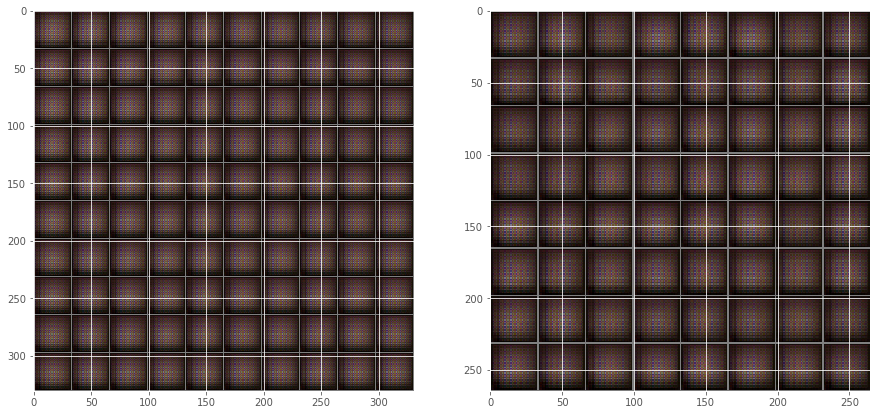

Model saved in file: ././gan.ckpt-0


In [38]:
t_i = 0
batch_i = 0
epoch_i = 0
n_files = len(files)

if not os.path.exists('imgs'):
    os.makedirs('imgs')
    
while epoch_i < n_epochs:

    batch_i += 1
    batch_xs = sess.run(batch) / 255.0
    batch_zs = np.random.uniform(
        0.0, 1.0, [batch_size, n_latent]).astype(np.float32)

    real_cost, fake_cost = sess.run([
        loss_D_real, loss_D_fake],
        feed_dict={
            X: batch_xs,
            Z: batch_zs})
    real_cost = np.mean(real_cost)
    fake_cost = np.mean(fake_cost)
    
    if (batch_i % 20) == 0:
        print(batch_i, 'real:', real_cost, '/ fake:', fake_cost)

    gen_update = True
    dis_update = True

    if real_cost > (equilibrium + margin) or \
       fake_cost > (equilibrium + margin):
        gen_update = False

    if real_cost < (equilibrium - margin) or \
       fake_cost < (equilibrium - margin):
        dis_update = False

    if not (gen_update or dis_update):
        gen_update = True
        dis_update = True

    if gen_update:
        sess.run(opt_g,
            feed_dict={
                Z: batch_zs,
                lr_g: learning_rate})
    if dis_update:
        sess.run(opt_d,
            feed_dict={
                X: batch_xs,
                Z: batch_zs,
                lr_d: learning_rate})

    if batch_i % (n_files // batch_size) == 0:
        batch_i = 0
        epoch_i += 1
        print('---------- EPOCH:', epoch_i)
        
        # Plot example reconstructions from latent layer
        recon = sess.run(G, feed_dict={Z: zs})

        recon = np.clip(recon, 0, 1)
        m1 = utils.montage(recon.reshape([-1] + crop_shape),
                'imgs/manifold_%08d.png' % t_i)

        recon = sess.run(G, feed_dict={Z: batch_zs})

        recon = np.clip(recon, 0, 1)
        m2 = utils.montage(recon.reshape([-1] + crop_shape),
                'imgs/reconstructions_%08d.png' % t_i)
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 10))
        axs[0].imshow(m1)
        axs[1].imshow(m2)
        plt.show()
        t_i += 1

        # Save the variables to disk.
        save_path = saver.save(sess, "./" + ckpt_name,
                               global_step=batch_i,
                               write_meta_graph=False)
        print("Model saved in file: %s" % save_path)

In [39]:
# Tell all the threads to shutdown.
coord.request_stop()

# Wait until all threads have finished.
coord.join(threads)

# Clean up the session.
sess.close()

<a name="part-2---variational-auto-encoding-generative-adversarial-network-vaegan"></a>
# Part 2 - Variational Auto-Encoding Generative Adversarial Network (VAEGAN)

In our definition of the generator, we started with a feature vector, `Z`.  This feature vector was not connected to anything before it.  Instead, we had to randomly create its values using a random number generator of its `n_latent` values from -1 to 1, and this range was chosen arbitrarily.  It could have been 0 to 1, or -3 to 3, or 0 to 100.  In any case, the network would have had to learn to transform those values into something that looked like an image.  There was no way for us to take an image, and find the feature vector that created it.  In other words, it was not possible for us to *encode* an image.

The closest thing to an encoding we had was taking an image and feeding it to the discriminator, which would output a 0 or 1.  But what if we had another network that allowed us to encode an image, and then we used this network for both the discriminator and generative parts of the network?  That's the basic idea behind the VAEGAN: https://arxiv.org/abs/1512.09300.  It is just like the regular GAN, except we also use an encoder to create our feature vector `Z`.

We then get the best of both worlds: a GAN that looks more or less the same, but uses the encoding from an encoder instead of an arbitrary feature vector; and an autoencoder that can model an input distribution using a trained distance function, the discriminator, leading to nicer encodings/decodings.

Let's try to build it!  Refer to the paper for the intricacies and a great read.  Luckily, by building the `encoder` and `decoder` functions, we're almost there.  We just need a few more components and will change these slightly.

Let's reset our graph and recompose our network as a VAEGAN:

In [ ]:
tf.reset_default_graph()

<a name="batch-normalization"></a>
## Batch Normalization

You may have noticed from the `VAE` code that I've used something called "batch normalization".  This is a pretty effective technique for regularizing the training of networks by "reducing internal covariate shift".  The basic idea is that given a minibatch, we optimize the gradient for this small sample of the greater population.  But this small sample may have different characteristics than the entire population's gradient.  Consider the most extreme case, a minibatch of 1.  In this case, we overfit our gradient to optimize the gradient of the single observation.  If our minibatch is too large, say the size of the entire population, we aren't able to manuvuer the loss manifold at all and the entire loss is averaged in a way that doesn't let us optimize anything.  What we want to do is find a happy medium between a too-smooth loss surface (i.e. every observation), and a very peaky loss surface (i.e. a single observation).  Up until now we only used mini-batches to help with this.  But we can also approach it by "smoothing" our updates between each mini-batch.  That would effectively smooth the manifold of the loss space.  Those of you familiar with signal processing will see this as a sort of low-pass filter on the gradient updates.

In order for us to use batch normalization, we need another placeholder which is a simple boolean: True or False, denoting when we are training.  We'll use this placeholder to conditionally update batch normalization's statistics required for normalizing our minibatches.  Let's create the placeholder and then I'll get into how to use this.

In [ ]:
# placeholder for batch normalization
is_training = tf.placeholder(tf.bool, name='istraining')

The original paper that introduced the idea suggests to use batch normalization "pre-activation", meaning after the weight multipllication or convolution, and before the nonlinearity.  We can use the `tensorflow.contrib.layers.batch_norm` module to apply batch normalization to any input tensor give the tensor and the placeholder defining whether or not we are training.  Let's use this module and you can inspect the code inside the module in your own time if it interests you.

In [1]:
from tensorflow.contrib.layers import batch_norm
help(batch_norm)

Help on function batch_norm in module tensorflow.contrib.layers.python.layers.layers:

batch_norm(inputs, decay=0.999, center=True, scale=False, epsilon=0.001, activation_fn=None, param_initializers=None, updates_collections='update_ops', is_training=True, reuse=None, variables_collections=None, outputs_collections=None, trainable=True, batch_weights=None, fused=False, data_format='NHWC', scope=None)
    Adds a Batch Normalization layer from http://arxiv.org/abs/1502.03167.
    
      "Batch Normalization: Accelerating Deep Network Training by Reducing
      Internal Covariate Shift"
    
      Sergey Ioffe, Christian Szegedy
    
    Can be used as a normalizer function for conv2d and fully_connected.
    
    Note: When is_training is True the moving_mean and moving_variance need to be
    updated, by default the update_ops are placed in `tf.GraphKeys.UPDATE_OPS` so
    they need to be added as a dependency to the `train_op`, example:
    
      update_ops = tf.get_collection(tf.Grap

<a name="building-the-encoder-1"></a>
## Building the Encoder

We can now change our encoder to accept the `is_training` placeholder and apply `batch_norm` just before the activation function is applied:

In [ ]:
def encoder(x, is_training, channels, filter_sizes, activation=tf.nn.tanh, reuse=None):
    # Set the input to a common variable name, h, for hidden layer
    h = x

    print('encoder/input:', h.get_shape().as_list())
    # Now we'll loop over the list of dimensions defining the number
    # of output filters in each layer, and collect each hidden layer
    hs = []
    for layer_i in range(len(channels)):
        
        with tf.variable_scope('layer{}'.format(layer_i+1), reuse=reuse):
            # Convolve using the utility convolution function
            # This requirs the number of output filter,
            # and the size of the kernel in `k_h` and `k_w`.
            # By default, this will use a stride of 2, meaning
            # each new layer will be downsampled by 2.
            h, W = utils.conv2d(h, channels[layer_i],
                                k_h=filter_sizes[layer_i],
                                k_w=filter_sizes[layer_i],
                                d_h=2,
                                d_w=2,
                                reuse=reuse)
            
            h = batch_norm(h, is_training=is_training)

            # Now apply the activation function
            h = activation(h)
            print('layer:', layer_i, ', shape:', h.get_shape().as_list())
            
            # Store each hidden layer
            hs.append(h)

    # Finally, return the encoding.
    return h, hs

Let's now create the input to the network using a placeholder.  We can try a slightly larger image this time.  But be careful experimenting with much larger images as this is a big network.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
n_pixels = 64
n_channels = 3
input_shape = [None, n_pixels, n_pixels, n_channels]

# placeholder for the input to the network
X = tf.placeholder(...)

And now we'll connect the input to an encoder network.  We'll also use the `tf.nn.elu` activation instead.  Explore other activations but I've found this to make the training much faster (e.g. 10x faster at least!).  See the paper for more details: [Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs)
](http://arxiv.org/abs/1511.07289)

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
channels = [64, 64, 64]
filter_sizes = [5, 5, 5]
activation = tf.nn.elu
n_hidden = 128

with tf.variable_scope('encoder'):
    H, Hs = encoder(...
    Z = utils.linear(H, n_hidden)[0]

<a name="building-the-variational-layer"></a>
## Building the Variational Layer

In Session 3, we introduced the idea of Variational Bayes when we used the Variational Auto Encoder.  The variational bayesian approach requires a richer understanding of probabilistic graphical models and bayesian methods which we we're not able to go over in this course (it requires a few courses all by itself!).  For that reason, please treat this as a "black box" in this course.

For those of you that are more familiar with graphical models, Variational Bayesian methods attempt to model an approximate joint distribution of $Q(Z)$ using some distance function to the true distribution $P(X)$.  Kingma and Welling show how this approach can be used in a graphical model resembling an autoencoder and can be trained using KL-Divergence, or $KL(Q(Z) || P(X))$.  The distribution Q(Z) is the variational distribution, and attempts to model the lower-bound of the true distribution $P(X)$ through the minimization of the KL-divergence.  Another way to look at this is the encoder of the network is trying to model the parameters of a known distribution, the Gaussian Distribution, through a minimization of this lower bound.  We assume that this distribution resembles the true distribution, but it is merely a simplification of the true distribution.  To learn more about this, I highly recommend picking up the book by Christopher Bishop called "Pattern Recognition and Machine Learning" and reading the original Kingma and Welling paper on Variational Bayes.

Now back to coding, we'll create a general variational layer that does exactly the same thing as our VAE in session 3.  Treat this as a black box if you are unfamiliar with the math.  It takes an input encoding, `h`, and an integer, `n_code` defining how many latent Gaussians to use to model the latent distribution.  In return, we get the latent encoding from sampling the Gaussian layer, `z`, the mean and log standard deviation, as well as the prior loss, `loss_z`.

In [ ]:
def variational_bayes(h, n_code):
    # Model mu and log(\sigma)
    z_mu = tf.nn.tanh(utils.linear(h, n_code, name='mu')[0])
    z_log_sigma = 0.5 * tf.nn.tanh(utils.linear(h, n_code, name='log_sigma')[0])

    # Sample from noise distribution p(eps) ~ N(0, 1)
    epsilon = tf.random_normal(tf.pack([tf.shape(h)[0], n_code]))

    # Sample from posterior
    z = z_mu + tf.mul(epsilon, tf.exp(z_log_sigma))

    # Measure loss
    loss_z = -0.5 * tf.reduce_sum(
        1.0 + 2.0 * z_log_sigma - tf.square(z_mu) - tf.exp(2.0 * z_log_sigma),
        1)

    return z, z_mu, z_log_sigma, loss_z

Let's connect this layer to our encoding, and keep all the variables it returns.  Treat this as a black box if you are unfamiliar with variational bayes!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Experiment w/ values between 2 - 100
# depending on how difficult the dataset is
n_code = 32

with tf.variable_scope('encoder/variational'):
    Z, Z_mu, Z_log_sigma, loss_Z = variational_bayes(h=Z, n_code=n_code)

<a name="building-the-decoder-1"></a>
## Building the Decoder

In the GAN network, we built a decoder and called it the generator network.  Same idea here.  We can use these terms interchangeably.  Before we connect our latent encoding, `Z` to the decoder, we'll implement batch norm in our decoder just like we did with the encoder.  This is a simple fix: add a second argument for `is_training` and then apply batch normalization just after the `deconv2d` operation and just before the nonlinear `activation`.

In [ ]:
def decoder(z, is_training, dimensions, channels, filter_sizes,
            activation=tf.nn.elu, reuse=None):
    h = z
    for layer_i in range(len(dimensions)):
        with tf.variable_scope('layer{}'.format(layer_i+1), reuse=reuse):
            h, W = utils.deconv2d(x=h,
                               n_output_h=dimensions[layer_i],
                               n_output_w=dimensions[layer_i],
                               n_output_ch=channels[layer_i],
                               k_h=filter_sizes[layer_i],
                               k_w=filter_sizes[layer_i],
                               reuse=reuse)
            h = batch_norm(h, is_training=is_training)
            h = activation(h)
    return h

Now we'll build a decoder just like in Session 3, and just like our Generator network in Part 1.  In Part 1, we created `Z` as a placeholder which we would have had to feed in as random values.  However, now we have an explicit coding of an input image in `X` stored in `Z` by having created the encoder network.

In [ ]:
dimensions = [n_pixels // 8, n_pixels // 4, n_pixels // 2, n_pixels]
channels = [30, 30, 30, n_channels]
filter_sizes = [4, 4, 4, 4]
activation = tf.nn.elu
n_latent = n_code * (n_pixels // 16)**2

with tf.variable_scope('generator'):
    Z_decode = utils.linear(
        Z, n_output=n_latent, name='fc', activation=activation)[0]
    Z_decode_tensor = tf.reshape(
        Z_decode, [-1, n_pixels//16, n_pixels//16, n_code], name='reshape')
    G = decoder(
        Z_decode_tensor, is_training, dimensions,
        channels, filter_sizes, activation)

Now we need to build our discriminators.  We'll need to add a parameter for the `is_training` placeholder.  We're also going to keep track of every hidden layer in the discriminator.  Our encoder already returns the `Hs` of each layer.  Alternatively, we could poll the graph for each layer in the discriminator and ask for the correspond layer names.  We're going to need these layers when building our costs.

In [ ]:
def discriminator(X,
                  is_training,
                  channels=[50, 50, 50, 50],
                  filter_sizes=[4, 4, 4, 4],
                  activation=tf.nn.elu,
                  reuse=None):

    # We'll scope these variables to "discriminator_real"
    with tf.variable_scope('discriminator', reuse=reuse):
        H, Hs = encoder(
            X, is_training, channels, filter_sizes, activation, reuse)
        shape = H.get_shape().as_list()
        H = tf.reshape(
            H, [-1, shape[1] * shape[2] * shape[3]])
        D, W = utils.linear(
            x=H, n_output=1, activation=tf.nn.sigmoid, name='fc', reuse=reuse)
    return D, Hs

Recall the regular GAN and DCGAN required 2 discriminators: one for the generated samples in `Z`, and one for the input samples in `X`.  We'll do the same thing here.  One discriminator for the real input data, `X`, which the discriminator will try to predict as 1s, and another discriminator for the generated samples that go from `X` through the encoder to `Z`, and finally through the decoder to `G`.  The discriminator will be trained to try and predict these as 0s, whereas the generator will be trained to try and predict these as 1s.

In [ ]:
D_real, Hs_real = discriminator(X, is_training)
D_fake, Hs_fake = discriminator(G, is_training, reuse=True)

<a name="building-vaegan-loss-functions"></a>
## Building VAE/GAN Loss Functions

Let's now see how we can compose our loss.  We have 3 losses for our discriminator.  Along with measuring the binary cross entropy between each of them, we're going to also measure each layer's loss from our two discriminators using an l2-loss, and this will form our loss for the log likelihood measure.  The details of how these are constructed are explained in more details in the paper: https://arxiv.org/abs/1512.09300 - please refer to this paper for more details that are way beyond the scope of this course!  One parameter within this to pay attention to is `gamma`, which the authors of the paper suggest control the weighting between content and style, just like in Session 4's Style Net implementation.

In [ ]:
with tf.variable_scope('loss'):
    # Loss functions
    loss_D_llike = 0
    for h_real, h_fake in zip(Hs_real, Hs_fake):
        loss_D_llike += tf.reduce_sum(tf.squared_difference(
            utils.flatten(h_fake), utils.flatten(h_real)), 1)

    eps = 1e-12
    loss_real = tf.log(D_real + eps)
    loss_fake = tf.log(1 - D_fake + eps)
    loss_GAN = tf.reduce_sum(loss_real + loss_fake, 1)
    
    gamma = 0.75
    loss_enc = tf.reduce_mean(loss_Z + loss_D_llike)
    loss_dec = tf.reduce_mean(gamma * loss_D_llike - loss_GAN)
    loss_dis = -tf.reduce_mean(loss_GAN)

In [ ]:
nb_utils.show_graph(tf.get_default_graph().as_graph_def())

<a name="creating-the-optimizers"></a>
## Creating the Optimizers

We now have losses for our encoder, decoder, and discriminator networks.  We can connect each of these to their own optimizer and start training!  Just like with Part 1's GAN, we'll ensure each network's optimizer only trains its part of the network: the encoder's optimizer will only update the encoder variables, the generator's optimizer will only update the generator variables, and the discriminator's optimizer will only update the discriminator variables.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
learning_rate = 0.0001

opt_enc = tf.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(
    loss_enc,
    var_list=[var_i for var_i in tf.trainable_variables()
              if ...])

opt_gen = tf.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(
    loss_dec,
    var_list=[var_i for var_i in tf.trainable_variables()
              if ...])

opt_dis = tf.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(
    loss_dis,
    var_list=[var_i for var_i in tf.trainable_variables()
              if var_i.name.startswith('discriminator')])

<a name="loading-the-dataset"></a>
## Loading the Dataset

We'll now load our dataset just like in Part 1.  Here is where you should explore with your own data!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
from libs import datasets, dataset_utils

batch_size = 64
n_epochs = 100
crop_shape = [n_pixels, n_pixels, n_channels]
crop_factor = 0.8
input_shape = [218, 178, 3]

# Try w/ CELEB first to make sure it works, then explore w/ your own dataset.
files = datasets.CELEB()
batch = dataset_utils.create_input_pipeline(
    files=files,
    batch_size=batch_size,
    n_epochs=n_epochs,
    crop_shape=crop_shape,
    crop_factor=crop_factor,
    shape=input_shape)

We'll also create a latent manifold just like we've done in Session 3 and Part 1.  This is a random sampling of 4 points in the latent space of `Z`.  We then interpolate between then to create a "hyper-plane" and show the decoding of 10 x 10 points on that hyperplane.

In [ ]:
n_samples = 10
zs = np.random.uniform(
    -1.0, 1.0, [4, n_code]).astype(np.float32)
zs = utils.make_latent_manifold(zs, n_samples)

Now create a session and create a coordinator to manage our queues for fetching data from the input pipeline and start our queue runners:

In [ ]:
# We create a session to use the graph
sess = tf.Session()
init_op = tf.global_variables_initializer()

saver = tf.train.Saver()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
sess.run(init_op)

Load an existing checkpoint if it exists to continue training.

In [ ]:
if os.path.exists("vaegan.ckpt"):
    saver.restore(sess, "vaegan.ckpt")
    print("GAN model restored.")

We'll also try resythesizing a test set of images.  This will help us understand how well the encoder/decoder network is doing:

In [ ]:
n_files = len(files)
test_xs = sess.run(batch) / 255.0
if not os.path.exists('imgs'):
    os.mkdir('imgs')
m = utils.montage(test_xs, 'imgs/test_xs.png')
plt.imshow(m)

<a name="training-1"></a>
## Training

Almost ready for training.  Let's get some variables which we'll need.  These are the same as Part 1's training process.  We'll keep track of `t_i` which we'll use to create images of the current manifold and reconstruction every so many iterations.  And we'll keep track of the current batch number within the epoch and the current epoch number.

In [ ]:
t_i = 0
batch_i = 0
epoch_i = 0
ckpt_name = './vaegan.ckpt'

Just like in Part 1, we'll train trying to maintain an equilibrium between our Generator and Discriminator networks.  You should experiment with the margin depending on how the training proceeds.

In [ ]:
equilibrium = 0.693
margin = 0.4

Now we'll train!  Just like Part 1, we measure the `real_cost` and `fake_cost`.  But this time, we'll always update the encoder.  Based on the performance of the real/fake costs, then we'll update generator and discriminator networks.  This will take a long time to produce something nice, but not nearly as long as the regular GAN network despite the additional parameters of the encoder and variational networks.  Be sure to monitor the reconstructions to understand when your network has reached the capacity of its learning!  For reference, on Celeb Net, I would use about 5 layers in each of the Encoder, Generator, and Discriminator networks using as input a 100 x 100 image, and a minimum of 200 channels per layer.  This network would take about 1-2 days to train on an Nvidia TITAN X GPU.

In [ ]:
while epoch_i < n_epochs:
    if batch_i % (n_files // batch_size) == 0:
        batch_i = 0
        epoch_i += 1
        print('---------- EPOCH:', epoch_i)

    batch_i += 1
    batch_xs = sess.run(batch) / 255.0
    real_cost, fake_cost, _ = sess.run([
        loss_real, loss_fake, opt_enc],
        feed_dict={
            X: batch_xs,
            is_training: True})
    real_cost = -np.mean(real_cost)
    fake_cost = -np.mean(fake_cost)

    gen_update = True
    dis_update = True

    if real_cost > (equilibrium + margin) or \
       fake_cost > (equilibrium + margin):
        gen_update = False

    if real_cost < (equilibrium - margin) or \
       fake_cost < (equilibrium - margin):
        dis_update = False

    if not (gen_update or dis_update):
        gen_update = True
        dis_update = True

    if gen_update:
        sess.run(opt_gen, feed_dict={
            X: batch_xs,
            is_training: True})
    if dis_update:
        sess.run(opt_dis, feed_dict={
            X: batch_xs,
            is_training: True})

    if batch_i % 50 == 0:
        print('real:', real_cost, '/ fake:', fake_cost)

        # Plot example reconstructions from latent layer
        recon = sess.run(G, feed_dict={
                Z: zs,
                is_training: False})

        recon = np.clip(recon, 0, 1)
        m1 = utils.montage(recon.reshape([-1] + crop_shape),
                'imgs/manifold_%08d.png' % t_i)

        # Plot example reconstructions
        recon = sess.run(G, feed_dict={
                X: test_xs,
                is_training: False})
        recon = np.clip(recon, 0, 1)
        m2 = utils.montage(recon.reshape([-1] + crop_shape),
                'imgs/reconstruction_%08d.png' % t_i)
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 10))
        axs[0].imshow(m1)
        axs[1].imshow(m2)
        plt.show()
        
        t_i += 1
        

    if batch_i % 200 == 0:
        # Save the variables to disk.
        save_path = saver.save(sess, "./" + ckpt_name,
                               global_step=batch_i,
                               write_meta_graph=False)
        print("Model saved in file: %s" % save_path)

In [ ]:
# One of the threads has issued an exception.  So let's tell all the
# threads to shutdown.
coord.request_stop()

# Wait until all threads have finished.
coord.join(threads)

# Clean up the session.
sess.close()

<a name="part-3---latent-space-arithmetic"></a>
# Part 3 - Latent-Space Arithmetic

<a name="loading-the-pre-trained-model"></a>
## Loading the Pre-Trained Model

We're now going to work with a pre-trained VAEGAN model on the Celeb Net dataset.  Let's load this model:

In [ ]:
tf.reset_default_graph()

In [ ]:
from libs import celeb_vaegan as CV

In [ ]:
net = CV.get_celeb_vaegan_model()

We'll load the graph_def contained inside this dictionary.  It follows the same idea as the `inception`, `vgg16`, and `i2v` pretrained networks.  It is a dictionary with the key `graph_def` defined, with the graph's pretrained network.  It also includes `labels` and a `preprocess` key.  We'll have to do one additional thing which is to turn off the random sampling from variational layer.  This isn't really necessary but will ensure we get the same results each time we use the network.  We'll use the `input_map` argument to do this.  Don't worry if this doesn't make any sense, as we didn't cover the variational layer in any depth.  Just know that this is removing a random process from the network so that it is completely deterministic.  If we hadn't done this, we'd get slightly different results each time we used the network (which may even be desirable for your purposes).

In [ ]:
sess = tf.Session()
g = tf.get_default_graph()
tf.import_graph_def(net['graph_def'], name='net', input_map={
        'encoder/variational/random_normal:0': np.zeros(512, dtype=np.float32)})
names = [op.name for op in g.get_operations()]
print(names)

Now let's get the relevant parts of the network: `X`, the input image to the network, `Z`, the input image's encoding, and `G`, the decoded image.  In many ways, this is just like the Autoencoders we learned about in Session 3, except instead of `Y` being the output, we have `G` from our generator!  And the way we train it is very different: we use an adversarial process between the generator and discriminator, and use the discriminator's own distance measure to help train the network, rather than pixel-to-pixel differences.

In [ ]:
X = g.get_tensor_by_name('net/x:0')
Z = g.get_tensor_by_name('net/encoder/variational/z:0')
G = g.get_tensor_by_name('net/generator/x_tilde:0')

Let's get some data to play with:

In [ ]:
files = datasets.CELEB()
img_i = 50
img = plt.imread(files[img_i])
plt.imshow(img)

Now preprocess the image, and see what the generated image looks like (i.e. the lossy version of the image through the network's encoding and decoding).

In [ ]:
p = CV.preprocess(img)
synth = sess.run(G, feed_dict={X: p[np.newaxis]})

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(p)
axs[1].imshow(synth[0] / synth.max())

So we lost a lot of details but it seems to be able to express quite a bit about the image.  Our inner most layer, `Z`, is only 512 values yet our dataset was 200k images of 64 x 64 x 3 pixels (about 2.3 GB of information).  That means we're able to express our nearly 2.3 GB of information with only 512 values!  Having some loss of detail is certainly expected!

<a name="exploring-the-celeb-net-attributes"></a>
## Exploring the Celeb Net Attributes

Let's now try and explore the attributes of our dataset.  We didn't train the network with any supervised labels, but the Celeb Net dataset has 40 attributes for each of its 200k images.  These are already parsed and stored for you in the `net` dictionary:

In [ ]:
net.keys()

In [ ]:
len(net['labels'])

In [ ]:
net['labels']

Let's see what attributes exist for one of the celeb images:

In [ ]:
plt.imshow(img)
[net['labels'][i] for i, attr_i in enumerate(net['attributes'][img_i]) if attr_i]

<a name="find-the-latent-encoding-for-an-attribute"></a>
## Find the Latent Encoding for an Attribute

The Celeb Dataset includes attributes for each of its 200k+ images.  This allows us to feed into the encoder some images that we know have a *specific* attribute, e.g. "smiling".  We store what their encoding is and retain this distribution of encoded values.  We can then look at any other image and see how it is encoded, and slightly change the encoding by adding the encoded of our smiling images to it!  The result should be our image but with more smiling.  That is just insane and we're going to see how to do it.  First lets inspect our latent space:

In [ ]:
Z.get_shape()

We have 512 features that we can encode any image with.  Assuming our network is doing an okay job, let's try to find the `Z` of the first 100 images with the 'Bald' attribute:

In [ ]:
bald_label = net['labels'].index('Bald')

In [ ]:
bald_label

Let's get all the bald image indexes:

In [ ]:
bald_img_idxs = np.where(net['attributes'][:, bald_label])[0]

In [ ]:
bald_img_idxs

Now let's just load 100 of their images:

In [ ]:
bald_imgs = [plt.imread(files[bald_img_i])[..., :3]
             for bald_img_i in bald_img_idxs[:100]]

Let's see if the mean image looks like a good bald person or not:

In [ ]:
plt.imshow(np.mean(bald_imgs, 0).astype(np.uint8))

Yes that is definitely a bald person.  Now we're going to try to find the encoding of a bald person.  One method is to try and find every other possible image and subtract the "bald" person's latent encoding.  Then we could add this encoding back to any new image and hopefully it makes the image look more bald.  Or we can find a bunch of bald people's encodings and then average their encodings together.  This should reduce the noise from having many different attributes, but keep the signal pertaining to the baldness.

Let's first preprocess the images:

In [ ]:
bald_p = np.array([CV.preprocess(bald_img_i) for bald_img_i in bald_imgs])

Now we can find the latent encoding of the images by calculating `Z` and feeding `X` with our `bald_p` images:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
bald_zs = sess.run(Z, feed_dict=...

Now let's calculate the mean encoding:

In [ ]:
bald_feature = np.mean(bald_zs, 0, keepdims=True)

In [ ]:
bald_feature.shape

Let's try and synthesize from the mean bald feature now and see how it looks:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
bald_generated = sess.run(G, feed_dict=...

In [ ]:
plt.imshow(bald_generated[0] / bald_generated.max())

<a name="latent-feature-arithmetic"></a>
## Latent Feature Arithmetic

Let's now try to write a general function for performing everything we've just done so that we can do this with many different features.  We'll then try to combine them and synthesize people with the features we want them to have...

In [ ]:
def get_features_for(label='Bald', has_label=True, n_imgs=50):
    label_i = net['labels'].index(label)
    label_idxs = np.where(net['attributes'][:, label_i] == has_label)[0]
    label_idxs = np.random.permutation(label_idxs)[:n_imgs]
    imgs = [plt.imread(files[img_i])[..., :3]
            for img_i in label_idxs]
    preprocessed = np.array([CV.preprocess(img_i) for img_i in imgs])
    zs = sess.run(Z, feed_dict={X: preprocessed})
    return np.mean(zs, 0)

Let's try getting some attributes positive and negative features.  Be sure to explore different attributes!  Also try different values of `n_imgs`, e.g. 2, 3, 5, 10, 50, 100.  What happens with different values?

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Explore different attributes
z1 = get_features_for('Male', True, n_imgs=10)
z2 = get_features_for('Male', False, n_imgs=10)
z3 = get_features_for('Smiling', True, n_imgs=10)
z4 = get_features_for('Smiling', False, n_imgs=10)

In [ ]:
b1 = sess.run(G, feed_dict={Z: z1[np.newaxis]})
b2 = sess.run(G, feed_dict={Z: z2[np.newaxis]})
b3 = sess.run(G, feed_dict={Z: z3[np.newaxis]})
b4 = sess.run(G, feed_dict={Z: z4[np.newaxis]})

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(b1[0] / b1.max()), axs[0].set_title('Male'), axs[0].grid('off'), axs[0].axis('off')
axs[1].imshow(b2[0] / b2.max()), axs[1].set_title('Not Male'), axs[1].grid('off'), axs[1].axis('off')
axs[2].imshow(b3[0] / b3.max()), axs[2].set_title('Smiling'), axs[2].grid('off'), axs[2].axis('off')
axs[3].imshow(b4[0] / b4.max()), axs[3].set_title('Not Smiling'), axs[3].grid('off'), axs[3].axis('off')

Now let's interpolate between the "Male" and "Not Male" categories:

In [ ]:
notmale_vector = z2 - z1
n_imgs = 5
amt = np.linspace(0, 1, n_imgs)
zs = np.array([z1 + notmale_vector*amt_i for amt_i in amt])
g = sess.run(G, feed_dict={Z: zs})

In [ ]:
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 4))
for i, ax_i in enumerate(axs):
    ax_i.imshow(np.clip(g[i], 0, 1))
    ax_i.grid('off')
    ax_i.axis('off')

And the same for smiling:

In [ ]:
smiling_vector = z3 - z4
amt = np.linspace(0, 1, n_imgs)
zs = np.array([z4 + smiling_vector*amt_i for amt_i in amt])
g = sess.run(G, feed_dict={Z: zs})
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 4))
for i, ax_i in enumerate(axs):
    ax_i.imshow(np.clip(g[i] / g[i].max(), 0, 1))
    ax_i.grid('off')

There's also no reason why we have to be within the boundaries of 0-1.  We can extrapolate beyond, in, and around the space.

In [ ]:
n_imgs = 5
amt = np.linspace(-1.5, 2.5, n_imgs)
zs = np.array([z4 + smiling_vector*amt_i for amt_i in amt])
g = sess.run(G, feed_dict={Z: zs})
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 4))
for i, ax_i in enumerate(axs):
    ax_i.imshow(np.clip(g[i], 0, 1))
    ax_i.grid('off')
    ax_i.axis('off')

<a name="extensions"></a>
## Extensions

[Tom White](https://twitter.com/dribnet), Lecturer at Victoria University School of Design, also recently demonstrated an alternative way of interpolating using a sinusoidal interpolation.  He's created some of the most impressive generative images out there and luckily for us he has detailed his process in the arxiv preprint: https://arxiv.org/abs/1609.04468 - as well, be sure to check out his twitter bot, https://twitter.com/smilevector - which adds smiles to people :) - Note that the network we're using is only trained on aligned faces that are frontally facing, though this twitter bot is capable of adding smiles to any face.  I suspect that he is running a face detection algorithm such as AAM, CLM, or ASM, cropping the face, aligning it, and then running a similar algorithm to what we've done above.  Or else, perhaps he has trained a new model on faces that are not aligned.  In any case, it is well worth checking out!

Let's now try and use sinusoidal interpolation using his implementation in [plat](https://github.com/dribnet/plat/blob/master/plat/interpolate.py#L16-L24) which I've copied below:

In [ ]:
def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

In [ ]:
amt = np.linspace(0, 1, n_imgs)
zs = np.array([slerp(amt_i, z1, z2) for amt_i in amt])
g = sess.run(G, feed_dict={Z: zs})
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 4))
for i, ax_i in enumerate(axs):
    ax_i.imshow(np.clip(g[i], 0, 1))
    ax_i.grid('off')
    ax_i.axis('off')

It's certainly worth trying especially if you are looking to explore your own model's latent space in new and interesting ways.

Let's try and load an image that we want to play with.  We need an image as similar to the Celeb Dataset as possible.  Unfortunately, we don't have access to the algorithm they used to "align" the faces, so we'll need to try and get as close as possible to an aligned face image.  One way you can do this is to load up one of the celeb images and try and align an image to it using e.g. Photoshop or another photo editing software that lets you blend and move the images around.  That's what I did for my own face...

In [ ]:
img = plt.imread('parag.png')[..., :3]
img = CV.preprocess(img, crop_factor=1.0)[np.newaxis]

Let's see how the network encodes it:

In [ ]:
img_ = sess.run(G, feed_dict={X: img})
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img[0]), axs[0].grid('off')
axs[1].imshow(np.clip(img_[0] / np.max(img_), 0, 1)), axs[1].grid('off')

Notice how blurry the image is.  Tom White's preprint suggests one way to sharpen the image is to find the "Blurry" attribute vector:

In [ ]:
z1 = get_features_for('Blurry', True, n_imgs=25)
z2 = get_features_for('Blurry', False, n_imgs=25)
unblur_vector = z2 - z1

In [ ]:
z = sess.run(Z, feed_dict={X: img})

In [ ]:
n_imgs = 5
amt = np.linspace(0, 1, n_imgs)
zs = np.array([z[0] + unblur_vector * amt_i for amt_i in amt])
g = sess.run(G, feed_dict={Z: zs})
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 4))
for i, ax_i in enumerate(axs):
    ax_i.imshow(np.clip(g[i] / g[i].max(), 0, 1))
    ax_i.grid('off')
    ax_i.axis('off')

Notice that the image also gets brighter and perhaps other features than simply the bluriness of the image changes.  Tom's preprint suggests that this is due to the correlation that blurred images have with other things such as the brightness of the image, possibly due biases in labeling or how photographs are taken.   He suggests that another way to unblur would be to synthetically blur a set of images and find the difference in the encoding between the real and blurred images.  We can try it like so:

In [ ]:
from scipy.ndimage import gaussian_filter

idxs = np.random.permutation(range(len(files)))
imgs = [plt.imread(files[idx_i]) for idx_i in idxs[:100]]
blurred = []
for img_i in imgs:
    img_copy = np.zeros_like(img_i)
    for ch_i in range(3):
        img_copy[..., ch_i] = gaussian_filter(img_i[..., ch_i], sigma=3.0)
    blurred.append(img_copy)

In [ ]:
# Now let's preprocess the original images and the blurred ones
imgs_p = np.array([CV.preprocess(img_i) for img_i in imgs])
blur_p = np.array([CV.preprocess(img_i) for img_i in blurred])

# And then compute each of their latent features
noblur = sess.run(Z, feed_dict={X: imgs_p})
blur = sess.run(Z, feed_dict={X: blur_p})

In [ ]:
synthetic_unblur_vector = np.mean(noblur - blur, 0)

In [ ]:
n_imgs = 5
amt = np.linspace(0, 1, n_imgs)
zs = np.array([z[0] + synthetic_unblur_vector * amt_i for amt_i in amt])
g = sess.run(G, feed_dict={Z: zs})
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 4))
for i, ax_i in enumerate(axs):
    ax_i.imshow(np.clip(g[i], 0, 1))
    ax_i.grid('off')
    ax_i.axis('off')

For some reason, it also doesn't like my glasses very much.  Let's try and add them back.

In [ ]:
z1 = get_features_for('Eyeglasses', True)
z2 = get_features_for('Eyeglasses', False)
glass_vector = z1 - z2

In [ ]:
z = sess.run(Z, feed_dict={X: img})

In [ ]:
n_imgs = 5
amt = np.linspace(0, 1, n_imgs)
zs = np.array([z[0] + glass_vector * amt_i + unblur_vector * amt_i for amt_i in amt])
g = sess.run(G, feed_dict={Z: zs})
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 4))
for i, ax_i in enumerate(axs):
    ax_i.imshow(np.clip(g[i], 0, 1))
    ax_i.grid('off')
    ax_i.axis('off')

Well, more like sunglasses then.  Let's try adding everything in there now!

In [ ]:
n_imgs = 5
amt = np.linspace(0, 1.0, n_imgs)
zs = np.array([z[0] + glass_vector * amt_i + unblur_vector * amt_i + amt_i * smiling_vector for amt_i in amt])
g = sess.run(G, feed_dict={Z: zs})
fig, axs = plt.subplots(1, n_imgs, figsize=(20, 4))
for i, ax_i in enumerate(axs):
    ax_i.imshow(np.clip(g[i], 0, 1))
    ax_i.grid('off')
    ax_i.axis('off')

Well it was worth a try anyway.  We can also try with a lot of images and create a gif montage of the result:

In [ ]:
n_imgs = 5
amt = np.linspace(0, 1.5, n_imgs)
z = sess.run(Z, feed_dict={X: imgs_p})
imgs = []
for amt_i in amt:
    zs = z + synthetic_unblur_vector * amt_i + amt_i * smiling_vector
    g = sess.run(G, feed_dict={Z: zs})
    m = utils.montage(np.clip(g, 0, 1))
    imgs.append(m)

In [ ]:
gif.build_gif(imgs, saveto='celeb.gif')

In [ ]:
ipyd.Image(url='celeb.gif?i={}'.format(
        np.random.rand()), height=1000, width=1000)

Exploring multiple feature vectors and applying them to images from the celeb dataset to produce animations of a face, saving it as a GIF.  Recall you can store each image frame in a list and then use the `gif.build_gif` function to create a gif.  Explore your own syntheses and then include a gif of the different images you create as "celeb.gif" in the final submission.  Perhaps try finding unexpected synthetic latent attributes in the same way that we created a blur attribute.  You can check the documentation in scipy.ndimage for some other image processing techniques, for instance: http://www.scipy-lectures.org/advanced/image_processing/ - and see if you can find the encoding of another attribute that you then apply to your own images.  You can even try it with many images and use the `utils.montage` function to create a large grid of images that evolves over your attributes.  Or create a set of expressions perhaps.  Up to you just explore!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
imgs = []

... DO SOMETHING AWESOME ! ...

gif.build_gif(imgs=imgs, saveto='vaegan.gif')

<a name="part-4---character-level-recurrent-neural-network"></a>
# Part 4 - Character Level Recurrent Neural Network

Please visit [session-5-part2.ipynb](session-5-part2.ipynb) for the rest of the homework!